In [1]:
from numba import jit
import numbers
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.special import logsumexp

In [2]:
@jit(nopython=True)
def estado_ini(N):
    #Gera um estadon inicial aleatório para rede
    s = np.zeros(N,dtype=np.int8)
    for i in range(N):
        s[i] = np.sign(2*np.random.random()-1)
    return s

@jit(nopython=True)
def vizinhos(L,N):
    #Define a tabela de vizinhos 
    viz = np.zeros((N,4),dtype=np.int16)
    for k in range(N):
        viz[k,0]=k+1
        if (k+1) % L == 0: viz[k,0] = k+1-L
        viz[k,1] = k+L 
        if k > (N-L-1): viz[k,1] = k+L-N
        viz[k,2] = k-1 
        if k % L == 0: viz[k,2] = k+L-1
        viz[k,3] = k-L 
        if k < L: viz[k,3] = k+N-L
    return viz

@jit(nopython=True)
def energia(s,viz):
    #Calcula a energia da configuração s
    ener = 0 
    for i in range(N):
        h = s[viz[i,0]]+s[viz[i,1]]
        ener -= s[i]*h
    ener = int((ener+2*N)/4)
    return ener

@jit(nopython=True)
def minh(H, N):
    #Calcula o menor valor de H excluindo as energias proibidas
    minh=H[0]
    for i in range(2,N-1):
        if H[i] < minh: minh=H[i]
    if H[-1] < minh: minh=H[-1]
    return minh

@jit(nopython=True)
def wang_landau(N,Niter,flatness,ener,s,viz):
    # Algoritmo de Wang-Landau
    lnge = np.zeros(N+1,dtype=np.float64)
    H = np.zeros(N+1,dtype=np.int16)
    Hc = np.zeros(N+1,dtype=np.int16)
    mmicro = np.zeros(N+1,dtype=np.float64)
    lnf = 1.0
    m = s.sum()
    for it in range(Niter):
        #Iterações do algoritmo
        for imc in range(N):
            #Passo de Monte Carlo - percorre toda a rede
            k = np.random.randint(0,N-1)
            h = s[viz[k,0]]+s[viz[k,1]]+s[viz[k,2]]+s[viz[k,3]] # soma dos vizinhos
            ener2 = ener + int(s[k]*h*0.5)
            #print(lnge[ener]-lnge[ener2])
            if lnge[ener]>lnge[ener2]:
                s[k] = -s[k] 
                ener = ener2
                m -= 2*s[k]
            else:
                p = np.exp(lnge[ener]-lnge[ener2])
                if np.random.random() < p: 
                    s[k] = -s[k] 
                    ener = ener2
                    m -= 2*s[k]
            H[ener] += 1
            lnge[ener] += lnf
            mmicro[ener] += abs(m)
        if it%1000 == 0:
            hmed = float(H.sum())/float((N-1))
            hmin = minh(H, N)
            if hmin > (flatness*hmed):
                Hc += H
                H = np.zeros(N+1,dtype=np.int16)
                lnf = 0.5*lnf
#                 print("Histograma flat!",lnf)
#             if it%1000000 == 0: print("Iteração número",it)
        if lnf < 0.00000001: break
        
    mmicro = mmicro/Hc
    lnge = lnge - lnge[0]+np.log(2)
    return lnge,mmicro,ener,s



def media_termodinamica(g,lista,beta,n):
    maxi = max(g)
    g = np.exp(g-maxi)
    z=0
    e_i = 0
    e_ii = 0
    eMin = min(lista)
    
    for e in lista:
        e_1 = (4*e-2*n) - (4*eMin-2*n)
        z = z + (g[e]*np.exp(-beta*e_1))
        e_i = e_i + (e_1*g[e]*np.exp(-(beta*e_1)))
        e_ii = e_ii + ((e_1**2)*g[e]*np.exp(-(beta*e_1)))
    e_i = e_i/z
    e_ii = e_ii/z
    
    
    z = np.log(z)-(beta*eMin)
    z = z + maxi
    
    cv = (beta**2) * ((e_ii - (e_i**2)))/n
    media = (e_i + eMin)/n
    return z,media,cv

def set_list(n): 
    list_n = []
    #estados possíveis normalizados
    for i in range (n+1):
        if (i==1 or i==(n-1)):
            continue
        list_n.append(i)
    return list_n

def get_infos(temps, lnge, list_n, n, mmicro):
    x = []
    y = []
    ycv = []
    yft = []
    yst = []
    media = []
    mag = []
    for t in temps:
        beta = 1/t
        z, media, cv = media_termodinamica(lnge, list_n, beta, n)
        x.append(t)

        ycv.append(cv)

        y.append(media)

        ft = -((1/(n*beta))*np.log(z))
        yft.append(ft)

        st = (media-ft)/t
        yst.append(st)

        soma = 0
        maxi = max(lnge)
        for e in list_n:
            e_i = 4*e-2*n
            verify_value = logsumexp((mmicro[e]*lnge[e]*np.exp(-(beta*e_i)))/(z-maxi))
            soma += verify_value
        mag.append(soma)
    
    return x, y, ycv, yft, yst, media, mag

In [12]:
Niter=10000000  # Número máximo de passos de Monte Carlo (iterações do algoritmo)
flatness = 0.8  # Condição para zerar o histograma e diminuir lnf quando
                # min(Histogram) > average(Histogram)*flattness
Ls=[6,12,18]

temps = np.linspace(1,5,401)

for L in Ls:
    N=L*L           # Total de sítios da rede
    print("Simulação do modelo de Ising 2D pelo método de Wang-Landau")
    print("Rede quadrada",L,"x",L)
    
    if(L == 6):
        s6 = estado_ini(N)
        viz6 = vizinhos(L,N)
        ener6 = energia(s6,viz6)
        lnge6,mmicro6,ener6,s6 = wang_landau(N, Niter, flatness, ener6, s6, viz6)
        list6 = set_list(N)
        x6, y6, ycv6, yft6, yst6, media6, mag6 = get_infos(temps, lnge6, list6, N, mmicro6)
    if(L == 12):
        s12 = estado_ini(N)
        viz12 = vizinhos(L,N)
        ener12 = energia(s12,viz12)
        lnge12,mmicro12,ener12,s12 = wang_landau(N, Niter, flatness, ener12, s12, viz12)
        list12 = set_list(N)
        x12, y12, ycv12, yft12, yst12, media12, mag12 = get_infos(temps, lnge12, list12, N, mmicro12)
    if(L == 18):
        s18 = estado_ini(N)
        viz18 = vizinhos(L,N)
        ener18 = energia(s18,viz18)
        lnge18,mmicro18,ener18,s18 = wang_landau(N, Niter, flatness, ener18, s18, viz18)
        list18 = set_list(N)
        x18, y18, ycv18, yft18, yst18, media18, mag18 = get_infos(temps, lnge18, list18, N, mmicro18)

Simulação do modelo de Ising 2D pelo método de Wang-Landau
Rede quadrada 6 x 6
Simulação do modelo de Ising 2D pelo método de Wang-Landau
Rede quadrada 12 x 12


<ipython-input-11-1a551426fedc>:151: RuntimeWarning: invalid value encountered in double_scalars
  soma += verify_value


Simulação do modelo de Ising 2D pelo método de Wang-Landau
Rede quadrada 18 x 18


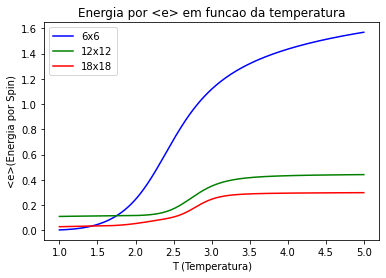

In [13]:
plt.plot(x6, y6, label = '6x6', color='blue')
plt.plot(x12, y12, label = '12x12', color='green')
plt.plot(x18, y18, label = '18x18', color='red')
plt.title('Energia por <e> em funcao da temperatura')
plt.xlabel('T (Temperatura)')
plt.ylabel('<e>(Energia por Spin)')
plt.legend()
plt.show()

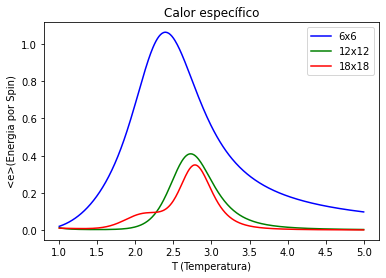

In [14]:
plt.plot(x6, ycv6, label = '6x6', color='blue')
plt.plot(x12, ycv12, label = '12x12', color='green')
plt.plot(x18, ycv18, label = '18x18', color='red')
plt.title('Calor específico')
plt.xlabel('T (Temperatura)')
plt.ylabel('<e>(Energia por Spin)')
plt.legend()
plt.show()

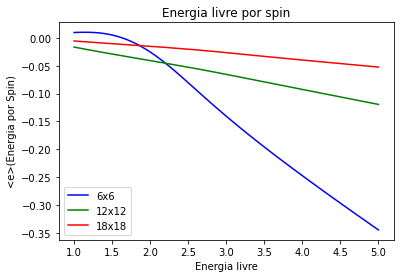

In [15]:
plt.plot(x6, yft6, label = '6x6', color='blue')
plt.plot(x12, yft12, label = '12x12', color='green')
plt.plot(x18, yft18, label = '18x18', color='red')
plt.title('Energia livre por spin')
plt.xlabel('Energia livre')
plt.ylabel('<e>(Energia por Spin)')
plt.legend()
plt.show()


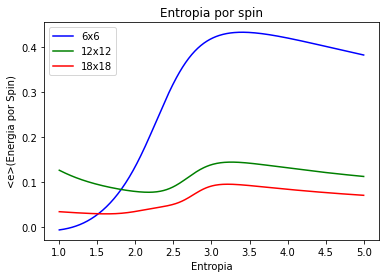

In [16]:
plt.plot(x6, yst6, label = '6x6', color='blue')
plt.plot(x12, yst12, label = '12x12', color='green')
plt.plot(x18, yst18, label = '18x18', color='red')
plt.title('Entropia por spin')
plt.xlabel('Entropia')
plt.ylabel('<e>(Energia por Spin)')
plt.legend()
plt.show()

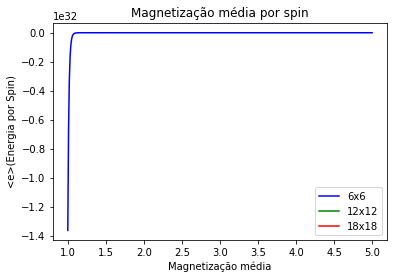

In [17]:
plt.plot(x6, mag6, label = '6x6', color='blue')
plt.plot(x12, mag12, label = '12x12', color='green')
plt.plot(x18, mag18, label = '18x18', color='red')
plt.title('Magnetização média por spin')
plt.xlabel('Magnetização média')
plt.ylabel('<e>(Energia por Spin)')
plt.legend()
plt.show()